# Recommending top 10 Movies 

### Importing Packages

In [23]:
#importing packages
import re
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import warnings
warnings.filterwarnings("ignore")
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Data Preperartion

In [74]:
#Loading Datasets

ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
links =  pd.read_csv('ml-latest-small/links.csv')

In [75]:
#Classifying user as 1 who rated move >=4 otherwise 0
ratings['Like']=np.where(ratings['rating']>=4,1,0)

#Dropping rating column
ratings = ratings.drop(['rating'],axis=1) 

# creating a pivot using userId and movieId of ratings table
ratings_pivot = ratings.pivot(index = 'userId', columns ='movieId', values = 'Like').fillna(0)

#creating a co-occurence matrix , Each entry Xi,j is the number of users who like both movie i and j
rating_co_occ = ratings_pivot.T.dot(ratings_pivot)

# converting rating_co_occ to matrix with diagonal elements as 0 so that movie does not compare to itself
actual_reco=rating_co_occ.as_matrix()
np.fill_diagonal(actual_reco, 0)

# converting matrix to tensor using torch

actual_reco = torch.from_numpy(rating_co_occ.as_matrix()).float()
actual_reco

tensor([[ 0., 21., 11.,  ...,  0.,  0.,  0.],
        [21.,  0.,  5.,  ...,  0.,  0.,  0.],
        [11.,  5.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

## Reference Matrix to check actual recommendation

In [76]:
# creating a reference table with movieId, indexes of movies, movie name and genre
# We will use dataframe to compare actually highest rated movies for a given movie with 
# the movies recommended by the model. (Used in End)

reference = rating_co_occ.reset_index()
reference = reference.merge(movies_ds, on='movieId', how='inner')
reference["movie"]=reference["title"].str.split('(',expand=True)[0].str.strip().str.lower()
reference.head(3)

,movieId,1,2,3,4,5,6,7,8,9,...,193573,193579,193581,193583,193585,193587,193609,title,genres,movie
0,1,0.0,21.0,11.0,0.0,7.0,27.0,7.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,toy story
1,2,21.0,0.0,5.0,0.0,4.0,8.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jumanji (1995),Adventure|Children|Fantasy,jumanji
2,3,11.0,5.0,0.0,0.0,4.0,4.0,5.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Grumpier Old Men (1995),Comedy|Romance,grumpier old men


## One Hot Encoded Movie Matrix For Input

In [77]:
# creating a One Hot Encoded matrix for each movie
# We will use this matrix to train movie Embeddings 

#Select uniue movies for which rating is given
data = reference["movieId"].unique()
values = array(data)



label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)


onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])




# Converting One Hot Encoded Matrix into Tensor to use with as input in Pytorch Module
movies_tensor = torch.from_numpy(onehot_encoded).float()
movies_tensor= torch.tensor(movies_tensor)
print(movies_tensor)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


## Building Model to train Movie Embeddings

In [78]:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724

# We will store loss after every iteration
loss_array =[]

# Create X and Y Tensors to hold inputs and outputs
x = movies_tensor
y = actual_reco

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Linear(D_in, H,bias=0)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="sum")



learning_rate = 0.01

# Using ADAM as choice of Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(201):
    # Forward pass: compute predicted y by passing x to the model.
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)

    # Setting Diagonals of predicted score matrix to zero
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print("iteration:",t, " Loss:",loss.item())
        loss_array.append(loss)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iteration: 0  Loss: 63482980.0


KeyboardInterrupt: 

#### Loss of cost function after 200 iterations is:

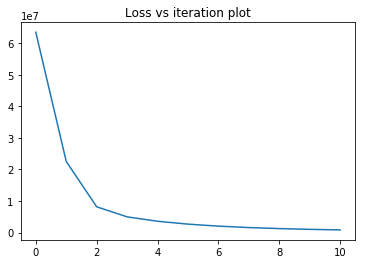

In [61]:
# plot of loss vs interations
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

## Recommending top 10 movies

In [43]:
# Creating a prediction function to give movie recommendations from Model

def prediction(moviename):
    
    #getting tensor for movie
    moviename= moviename.lower()
    idx = reference[reference["movie"]== moviename].index[0]   
    movie = movies_tensor[idx]
    movie = movie.reshape(1,movie.shape[0])
    
    #storing weight vector from model
    for name, param in model.named_parameters():
        weight_vector = param
    
    # prediction for given movie
    movie_i = model(movie)
    pred = torch.mm(movie_i,weight_vector)
    
    # movie index value sorted from min to max for predicted score values
    
    pred_idx = (-np.asanyarray(pred[0].detach().numpy())).argsort()[:10]
    
    # Getting title of recommended movie from Reference Dataframe
    recommendations = reference["title"].iloc[pred_idx]
    
    return recommendations
    

In [35]:
# Creating a function to see top 10 movies recommendation for a movie in Xij matrix

def observed_reco(moviename):
    
    # Getting Index of Movie from MovieId
    idx = reference[reference["movie"]== moviename].index[0]
    
    # Sorting top 10 movie indexes from Co-Occurence Matrix
    obs_idx = (-np.asanyarray(rating_co_occ.iloc[idx])).argsort()[:10]
    
    # Getting movie title from top 10 movie indexes
    recommendations = reference["title"].iloc[obs_idx]
    
    return recommendations

#### Top 10 movie prediction for Apollo 13

In [54]:
movie = "apollo 13"
predicted = prediction(movie)
observed = observed_reco(movie)
display("Model Predictions for "+str(movie),predicted,"Actual Predictions for "+str(movie), observed)

'Model Predictions for apollo 13'

314                          Forrest Gump (1994)
277             Shawshank Redemption, The (1994)
257                          Pulp Fiction (1994)
510             Silence of the Lambs, The (1991)
123                             Apollo 13 (1995)
97                             Braveheart (1995)
418                         Jurassic Park (1993)
398                         Fugitive, The (1993)
461                      Schindler's List (1993)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

'Actual Predictions for apollo 13'

277             Shawshank Redemption, The (1994)
314                          Forrest Gump (1994)
257                          Pulp Fiction (1994)
418                         Jurassic Park (1993)
510             Silence of the Lambs, The (1991)
398                         Fugitive, The (1993)
97                             Braveheart (1995)
461                      Schindler's List (1993)
507            Terminator 2: Judgment Day (1991)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

#### Top 10 movie recommendations for Toy Story

In [53]:
movie = "toy story"
predicted = prediction(movie)
observed = observed_reco(movie)
display("Model Predictions for "+str(movie),predicted,"Actual Predictions for "+str(movie), observed)

#display("Model Predictions:",prediction("toy story"),"Actual Predictions:", observed_reco("toy story"))

'Model Predictions for toy story'

277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
224             Star Wars: Episode IV - A New Hope (1977)
1938                                   Matrix, The (1999)
897     Star Wars: Episode V - The Empire Strikes Back...
899     Raiders of the Lost Ark (Indiana Jones and the...
0                                        Toy Story (1995)
910     Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object

'Actual Predictions for toy story'

277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
224             Star Wars: Episode IV - A New Hope (1977)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
897     Star Wars: Episode V - The Empire Strikes Back...
1938                                   Matrix, The (1999)
418                                  Jurassic Park (1993)
899     Raiders of the Lost Ark (Indiana Jones and the...
910     Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object

#### Top 10 movie predictions for Home Alone

In [60]:
movie = "home alone"
predicted = prediction(movie)
observed = observed_reco(movie)
display("Model Predictions for "+str(movie),predicted,"Actual Predictions for "+str(movie), observed)


'Model Predictions for home alone'

314                                   Forrest Gump (1994)
504                                     Home Alone (1990)
418                                  Jurassic Park (1993)
506                                        Aladdin (1992)
277                      Shawshank Redemption, The (1994)
322                                 Lion King, The (1994)
1938                                   Matrix, The (1999)
224             Star Wars: Episode IV - A New Hope (1977)
0                                        Toy Story (1995)
897     Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object

'Actual Predictions for home alone'

314                   Forrest Gump (1994)
418                  Jurassic Park (1993)
277      Shawshank Redemption, The (1994)
506                        Aladdin (1992)
322                 Lion King, The (1994)
507     Terminator 2: Judgment Day (1991)
0                        Toy Story (1995)
510      Silence of the Lambs, The (1991)
1938                   Matrix, The (1999)
257                   Pulp Fiction (1994)
Name: title, dtype: object